In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline

input_path = './chest_XrayCat/'
classes = ['NORMAL', 'VIRAL', 'BACTERIAL']

img_dims = 150
epochs = 25
batch_size = 96

def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.3, shear_range=0.2, vertical_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical', # no longer a binary output
        shuffle=True)

    test_gen = test_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/VIRAL/', '/BACTERIAL/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/VIRAL/':
                label = 1
            elif cond =='/BACTERIA/':
                label = 2
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [2]:
# for _set in ['train', 'test']:
#     n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
#     n_viral = len(os.listdir(input_path + _set + '/VIRAL'))
#     n_bacterial = len(os.listdir(input_path + _set + '/BACTERIAL'))
#     print('Set: {}, normal images: {}, viral images: {}, bacterial images: {}'.format(
#         _set, n_normal, n_viral, n_bacterial))

train_gen, test_gen, test_data, test_labels = process_data(
    img_dims, batch_size)

Found 5216 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [3]:

from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing, layers

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))

model.add(layers.SeparableConv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.SeparableConv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.SeparableConv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.SeparableConv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.SeparableConv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.SeparableConv2D(256, (3, 3), activation="relu", padding="same"))
model.add(layers.SeparableConv2D(256, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding="valid"))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')

In [5]:
hist = model.fit(
    train_gen, steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs, validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce, tensorboard_callback])

Epoch 1/25
54/54 [==============================] - 174s 3s/step - loss: 0.9312 - accuracy: 0.5800 - val_loss: 1.0941 - val_accuracy: 0.3733
Epoch 2/25
54/54 [==============================] - 169s 3s/step - loss: 0.6117 - accuracy: 0.7325 - val_loss: 1.0718 - val_accuracy: 0.6806
Epoch 3/25
54/54 [==============================] - 170s 3s/step - loss: 0.5861 - accuracy: 0.7458 - val_loss: 1.0620 - val_accuracy: 0.3993

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/25
54/54 [==============================] - 170s 3s/step - loss: 0.5482 - accuracy: 0.7675 - val_loss: 1.0667 - val_accuracy: 0.3906
Epoch 5/25
54/54 [==============================] - 170s 3s/step - loss: 0.5445 - accuracy: 0.7717 - val_loss: 1.0765 - val_accuracy: 0.3872

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 6/25
54/54 [==============================] - 166s 3s/step - loss: 0.5309 - accuracy: 0.7653 - val_loss: 1.1012 - val_accurac

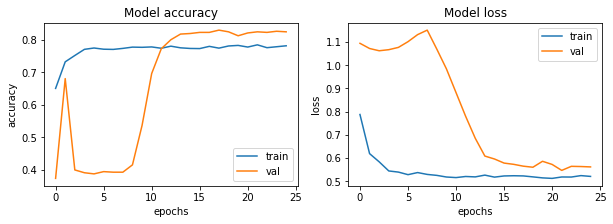

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [7]:
results = model.evaluate(test_gen)

acc = results[1] * 100

print('TEST METRICS ----------------------')
print('Accuracy: {:.2f}%'.format(acc))

print('\nTRAIN METRIC ----------------------')
print('Accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

7/7 [==============================] - 5s 689ms/step - loss: 0.5638 - accuracy: 0.8219
TEST METRICS ----------------------
Accuracy: 82.19%

TRAIN METRIC ----------------------
Accuracy: 78.16


In [8]:
model.save('./models/cat_' + str(epochs) + '_adam_b' + str(batch_size) + '_a' + str(int(acc)))

INFO:tensorflow:Assets written to: ./models/cat_25_adam_b96_a85/assets


# Test Model

In [1]:
from tensorflow.keras.models import load_model

model_to_load = 'cat_25_adam_b96_a86'

model = None
model = load_model('./models/' + model_to_load)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
separable_conv2d (SeparableC (None, None, None, 64)    2400      
_________________________________________________________________
separable_conv2d_1 (Separabl (None, None, None, 64)    4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    2

In [ ]:
results = model.evaluate(test_gen)

acc = results[1] * 100

print('TEST METRICS ----------------------')
print('Accuracy: {:.2f}%'.format(acc))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
INPUT_PATH = '/home/lucien/Work/TORAY/IA/chest_XrayCat/test'

res = []
i = 0
error = 0

for cond in ['/NORMAL/', '/VIRAL/', '/BACTERIAL/']:  # for each folder
    for img in os.listdir(INPUT_PATH + cond):  # for each image
        img_array = []
        # Import img
        img = plt.imread(INPUT_PATH + cond + img)
        img = cv2.resize(img, (img_dims, img_dims))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        img_array.append(img)
        img_array = np.array(img_array)
        # Feed img to CNN
        predictions = model.predict(img_array)
        # Retrieve prediction
        score = "{:.2f}%".format(np.max(predictions) * 100)
        predictions = np.argmax(predictions)
        res.append([predictions, score])
print(res)